In [7]:
from PhoBERT import PhoBERTTextPreprocessor, VietnameseNewsDataset, PhoBERTClassifier, PhoBERTTrainer
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [9]:
# Kiểm tra GPU / chọn device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"PyTorch version: {torch.__version__}")
print(f"Device selected: {DEVICE}")

if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠️ CUDA not available. Training will run on CPU (very slow).")

PyTorch version: 2.7.1+cu126
Device selected: cpu
⚠️ CUDA not available. Training will run on CPU (very slow).


In [8]:
class_names = [
    "Technology",     # 0
    "Travel",         # 1
    "Education",      # 2
    "Entertainment",  # 3
    "Science",        # 4
    "Business",       # 5
    "Law",            # 6
    "Health",         # 7
    "World",          # 8
    "Sport",          # 9
    "News",           # 10
    "Vehicle",        # 11
    "Life"            # 12
]

preprocessor_train = PhoBERTTextPreprocessor(
        phobert_model='vinai/phobert-base',
        max_length=64
)

# ==============================
# Split dataset -> train/val/test (8:1:1)
# (chỉ tạo nếu chưa có file)
# ==============================
SOURCE_CSV = 'data/preprocess/data_full_description_clean.csv'
TRAIN_CSV = 'data/preprocess/data_full_description_train_80.csv'
VAL_CSV = 'data/preprocess/data_full_description_val_10.csv'
TEST_CSV = 'data/preprocess/data_full_description_test_10.csv'

if not (os.path.exists(TRAIN_CSV) and os.path.exists(VAL_CSV) and os.path.exists(TEST_CSV)):
    df = pd.read_csv(SOURCE_CSV)
    if 'label' not in df.columns:
        raise ValueError("SOURCE_CSV must contain column 'label'")

    # 1) Train = 80%, Temp = 20%
    train_df, temp_df = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df['label'],
        shuffle=True,
    )

    # 2) Val = 10%, Test = 10% (split temp 50/50)
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.5,
        random_state=42,
        stratify=temp_df['label'],
        shuffle=True,
    )

    os.makedirs(os.path.dirname(TRAIN_CSV), exist_ok=True)
    train_df.to_csv(TRAIN_CSV, index=False)
    val_df.to_csv(VAL_CSV, index=False)
    test_df.to_csv(TEST_CSV, index=False)

    print(
        f"✅ Split done: train={len(train_df):,} | val={len(val_df):,} | test={len(test_df):,} "
        f"(total={len(df):,})"
    )
else:
    print("✅ Split files already exist. Skipping split.")

print(f"   Train CSV: {TRAIN_CSV}")
print(f"   Val CSV:   {VAL_CSV}")
print(f"   Test CSV:  {TEST_CSV}")

# Load training dataset (title + description)
train_dataset = VietnameseNewsDataset(
    csv_file=TRAIN_CSV,
    preprocessor=preprocessor_train,
    max_title_words=20,
    max_description_words=120,
    title_col='title',
    description_col='description',
    label_col='label',
)

train_dataset.human_readable_class_names = class_names

# Load validation dataset (dùng label_encoder từ train)
val_dataset = VietnameseNewsDataset(
    csv_file=VAL_CSV,
    preprocessor=preprocessor_train,
    label_encoder=train_dataset.label_encoder,
    max_title_words=20,
    max_description_words=120,
    title_col='title',
    description_col='description',
    label_col='label',
)
val_dataset.human_readable_class_names = class_names

test_dataset = VietnameseNewsDataset(
    csv_file=TEST_CSV,
    preprocessor=preprocessor_train,
    label_encoder=train_dataset.label_encoder,
    max_title_words=20,
    max_description_words=120,
    title_col='title',
    description_col='description',
    label_col='label',
)
test_dataset.human_readable_class_names = class_names

print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"Number of classes: {len(train_dataset.label_encoder.classes_)}")
print(f"Classes: {train_dataset.label_encoder.classes_}")

if len(train_dataset.label_encoder.classes_) != len(class_names):
    print("⚠️ Warning: class_names length != number of encoded classes.")
    print("   Please verify label mapping (0..N-1) matches class_names order.")

>> Loading PhoBERT tokenizer from local: models/phobert-base
✅ Split files already exist. Skipping split.
   Train CSV: data/preprocess/data_full_description_train_80.csv
   Val CSV:   data/preprocess/data_full_description_val_10.csv
   Test CSV:  data/preprocess/data_full_description_test_10.csv
Training samples: 30,356
Validation samples: 3,794
Test samples: 3,795
Number of classes: 13
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


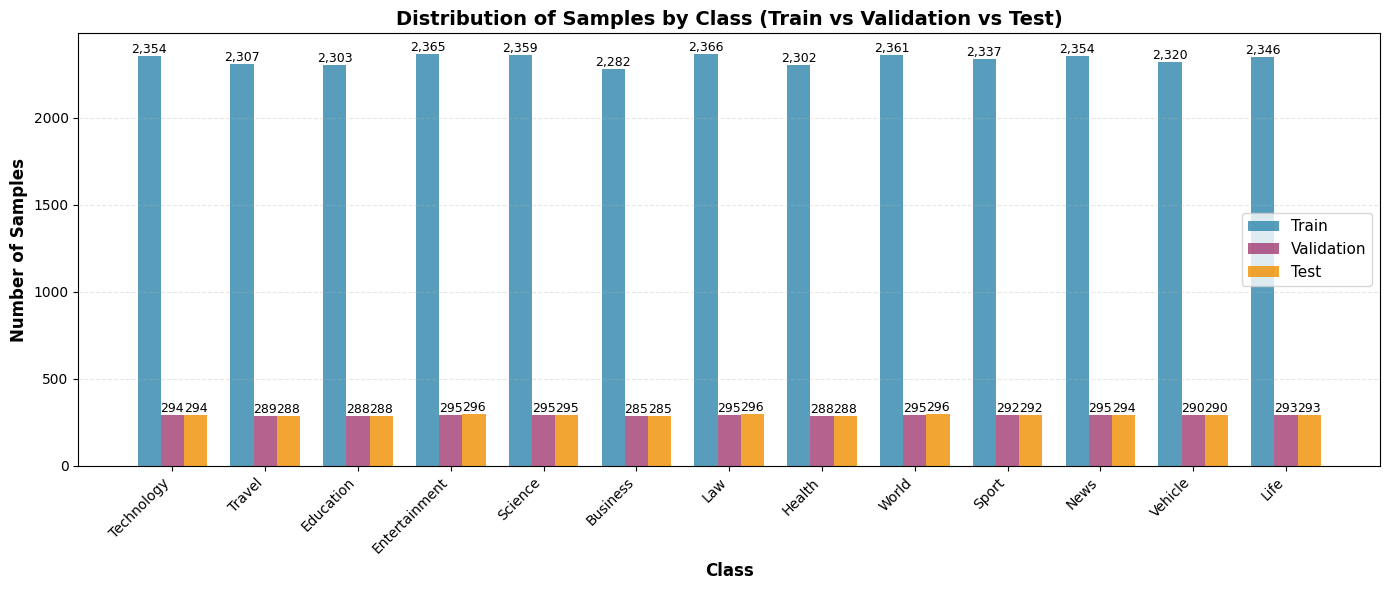


DATASET DISTRIBUTION SUMMARY

Total samples:
  Train: 30,356
  Validation: 3,794
  Test: 3,795

Samples per class:
Class                Train   Validation       Test      Total
------------------------------------------------------------
Technology           2,354          294        294      2,942
Travel               2,307          289        288      2,884
Education            2,303          288        288      2,879
Entertainment        2,365          295        296      2,956
Science              2,359          295        295      2,949
Business             2,282          285        285      2,852
Law                  2,366          295        296      2,957
Health               2,302          288        288      2,878
World                2,361          295        296      2,952
Sport                2,337          292        292      2,921
News                 2,354          295        294      2,943
Vehicle              2,320          290        290      2,900
Life             

In [9]:
# Load datasets
train_data = pd.read_csv(TRAIN_CSV)
val_data = pd.read_csv(VAL_CSV)
test_data = pd.read_csv(TEST_CSV)

# Count samples per label
train_counts = train_data['label'].value_counts().sort_index()
val_counts = val_data['label'].value_counts().sort_index()
test_counts = test_data['label'].value_counts().sort_index()

# Create bar chart
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(class_names))
width = 0.25

bars1 = ax.bar(x - width, train_counts, width, label='Train', color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x, val_counts, width, label='Validation', color='#A23B72', alpha=0.8)
bars3 = ax.bar(x + width, test_counts, width, label='Test', color='#F18F01', alpha=0.8)

# Add labels and title
ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Samples by Class (Train vs Validation vs Test)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*80}")
print("DATASET DISTRIBUTION SUMMARY")
print(f"{'='*80}")
print(f"\nTotal samples:")
print(f"  Train: {len(train_data):,}")
print(f"  Validation: {len(val_data):,}")
print(f"  Test: {len(test_data):,}")
print(f"\nSamples per class:")
print(f"{'Class':<15} {'Train':>10} {'Validation':>12} {'Test':>10} {'Total':>10}")
print(f"{'-'*60}")
for i, class_name in enumerate(class_names):
    train_count = train_counts[i] if i in train_counts.index else 0
    val_count = val_counts[i] if i in val_counts.index else 0
    test_count = test_counts[i] if i in test_counts.index else 0
    total = train_count + val_count + test_count
    print(f"{class_name:<15} {train_count:>10,} {val_count:>12,} {test_count:>10,} {total:>10,}")
print(f"{'='*80}")

In [10]:
title = "sinh con sàn nhà_tắm mới biết mình có_thai"
desc = "thuốc thai kinh hàng bụng to gái 24 sốc chuyển_dạ bé chào_đời phòng tắm gia_đình"
enc = preprocessor_train.encode_texts([title], text_pairs=[desc], padding="max_length", truncation=True, return_tensors="pt")

print("input_ids shape:", enc["input_ids"])
print("attention_mask shape:", enc["attention_mask"])

# Xem token thực sự (dễ hiểu nhất)
tokens = preprocessor_train.tokenizer.convert_ids_to_tokens(enc["input_ids"][0])
print(tokens)
print(len(tokens))

input_ids shape: tensor([[    0,   418,    73,  1407, 14177,    60,    55,    68,  6995,     2,
             2,   529,  1599,  3078,   119,  1569,   889,   238,  1173,  2111,
         20576,   308,  6706,   292,  2266,   161,     2,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1]])
attention_mask shape: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
['<s>', 'sinh', 'con', 'sàn', 'nhà_tắm', 'mới', 'biết', 'mình', 'có_thai', '</s>', '</s>', 'thuốc', 'thai', 'kinh', 'hàng', 'bụng', 'to', 'gái', '24', 'sốc', 'chuyển_dạ', 'bé', 'chào_đời', 'phòng', 'tắm', 'gia_đình', '</s>', '<

In [11]:
device = DEVICE

if device == "cuda":
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"✅ Training on GPU: {gpu_name}")
    print(f"   GPU Memory: {gpu_memory_gb:.1f} GB\n")
else:
    print("⚠️ Training on CPU")

# Dataloader params
NUM_WORKERS = 2 if device == "cuda" else 0
BATCH_SIZE = 16  # [16, 24, 32]
DROPOUT_RATE = 0.1  # [0.1, 0.4, 0.5]

# ========================================
# HYPERPARAMETERS
# ========================================
LEARNING_RATE = 2e-5  # [1e-5, 2e-5, 3e-5, 5e-5]
WEIGHT_DECAY = 0.01  # (0.0 -> 0.1)
NUM_EPOCHS = 5

ACCUMULATION_STEPS = 1

USE_PIN_MEMORY = True if device == "cuda" else False
PERSISTENT_WORKERS = True if NUM_WORKERS > 0 else False
PREFETCH_FACTOR = 2

# DataLoader configuration
dataloader_kwargs = {
    'pin_memory': USE_PIN_MEMORY,
    'num_workers': NUM_WORKERS,
}
if NUM_WORKERS > 0:
    dataloader_kwargs.update({
        'persistent_workers': PERSISTENT_WORKERS,
        'prefetch_factor': PREFETCH_FACTOR,
    })

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    **dataloader_kwargs,
 )

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    **dataloader_kwargs,
 )

# Print configuration summary
print(f"{'='*70}")
print("DATALOADER CONFIGURATION")
print(f"{'='*70}")
print(f"  Device:              {device.upper()}")
print(f"  Batch size:          {BATCH_SIZE}")
print(f"  Accumulation steps:  {ACCUMULATION_STEPS}")
print(f"  Effective batch:     {BATCH_SIZE * ACCUMULATION_STEPS}")
print(f"  Num workers:         {NUM_WORKERS}")
print(f"  Training batches:    {len(train_loader):,}")
print(f"  Validation batches:  {len(val_loader):,}")
print(f"{'='*70}")
print("\n🚀 Training Optimizations:")
print(f"  • Mixed precision (FP16): {'ON' if device=='cuda' else 'OFF'}")
print(f"  • Pin memory:             {'ON' if USE_PIN_MEMORY else 'OFF'}")
print(f"  • Persistent workers:     {'ON' if PERSISTENT_WORKERS else 'OFF'}")

NameError: name 'DEVICE' is not defined

In [ ]:
print("\n=== Initialize Model & Trainer ===")

# ========================================
# MODEL CONFIGURATION
# ========================================
FREEZE_PHOBERT = False

# Initialize model
num_classes = len(train_dataset.label_encoder.classes_)
model_train = PhoBERTClassifier(
    num_classes=num_classes,
    phobert_model='vinai/phobert-base',
    dropout_rate=DROPOUT_RATE,
    hidden_size=768,
    freeze_phobert=FREEZE_PHOBERT,
 )

trainable_params = sum(p.numel() for p in model_train.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_train.parameters())

if FREEZE_PHOBERT:
    print("Mode: Freeze PhoBERT (train FC layer only)")
    print(f"Trainable: {trainable_params:,} / {total_params:,} parameters")
else:
    print("Mode: Full fine-tuning")
    print(f"Trainable: {trainable_params:,} parameters")

# Initialize trainer
trainer = PhoBERTTrainer(
    model=model_train,
    device=device,
    label_smoothing=0.05,
 )

In [ ]:
print("\n=== Setup Optimizer & Learning Rate ===")


# Optimizer
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in model_train.named_parameters() if not any(nd in n for nd in no_decay)],
        'weight_decay': WEIGHT_DECAY
    },
    {
        'params': [p for n, p in model_train.named_parameters() if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0
    }
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=LEARNING_RATE,
    eps=1e-8
)

# Learning rate scheduler
total_steps = NUM_EPOCHS * len(train_loader) // ACCUMULATION_STEPS
warmup_steps = int(0.1 * total_steps)

scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay: {WEIGHT_DECAY}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Total training steps: {total_steps:,}")
print(f"Warmup steps: {warmup_steps:,}")
print(f"Gradient accumulation: {ACCUMULATION_STEPS}")
print(f"Scheduler: Cosine Annealing")

## 🚀 Advanced Improvements Applied

Để cải thiện hiệu suất mô hình và giảm thiểu overfitting tốt hơn nữa, tôi đã áp dụng các kỹ thuật nâng cao sau:

1.  **Label Smoothing (0.1):**
    *   Thay vì ép mô hình dự đoán xác suất 1.0 cho đúng class (hard target), chúng ta sử dụng soft target (ví dụ: 0.9 cho đúng class, chia đều 0.1 cho các class còn lại).
    *   **Tác dụng:** Giúp mô hình bớt "tự tin thái quá", học được các đặc trưng tổng quát hơn và giảm overfitting.

2.  **Correct Weight Decay Strategy:**
    *   Chỉ áp dụng Weight Decay cho các trọng số (weights) của Linear layers và Embeddings.
    *   **KHÔNG** áp dụng cho Bias và LayerNorm weights.
    *   **Tác dụng:** Đây là chuẩn mực khi fine-tune BERT, giúp training ổn định hơn.

3.  **Cosine Learning Rate Scheduler:**
    *   Thay vì giảm tuyến tính (Linear), LR sẽ giảm theo hình cosin.
    *   **Tác dụng:** Giữ LR cao lâu hơn ở giai đoạn đầu để học nhanh, và giảm rất chậm/mượt về cuối để hội tụ chính xác vào điểm cực trị.

4.  **Hyperparameters Adjustment:**
    *   **Epochs:** Tăng nhẹ lên 4 để Cosine Scheduler có đủ chu kỳ hoạt động hiệu quả.
    *   **Weight Decay:** Điều chỉnh về 0.01 (chuẩn cho AdamW khi đã group parameters đúng cách).

In [ ]:
print("\n" + "="*80)
print("START TRAINING")
print(f"DEVICE: {device.upper()}")
print("="*80)

import time

# ========================================
# TRAINING LOOP WITH EARLY STOPPING
# ========================================
use_amp = device == "cuda"

best_val_loss = float('inf')
best_val_acc = 0.0
patience = 2
patience_counter = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
}

total_training_start = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    print(f"\n{'='*80}")
    print(f"EPOCH {epoch + 1}/{NUM_EPOCHS}")
    print("="*80)

    # TRAINING
    train_loss, train_acc = trainer.train_epoch(
        train_loader=train_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        accumulation_steps=ACCUMULATION_STEPS,
        use_mixed_precision=use_amp,
        max_grad_norm=1.0,
        show_progress=True,
    )

    # VALIDATION
    print("\nEvaluating on validation set...")
    val_loss, val_acc = trainer.evaluate(
        val_loader=val_loader,
        show_progress=True,
        use_mixed_precision=use_amp,
    )

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print results
    epoch_time = time.time() - epoch_start_time
    print(f"\nEPOCH {epoch + 1} RESULTS:")
    print(f"{'-'*80}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"  Gap:        Loss delta={abs(train_loss-val_loss):.4f} | Acc delta={abs(train_acc-val_acc)*100:.2f}%")
    print(f"  Time:       {epoch_time/60:.2f} minutes ({epoch_time:.0f} seconds)")
    print(f"{'-'*80}")

    # EARLY STOPPING
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0

        # Save best model
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model_train.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'label_encoder': train_dataset.label_encoder,
            'history': history,
            'config': {
                'num_classes': num_classes,
                'batch_size': BATCH_SIZE,
                'learning_rate': LEARNING_RATE,
                'num_epochs': NUM_EPOCHS,
                'dropout_rate': DROPOUT_RATE,
                'weight_decay': WEIGHT_DECAY,
                'device': device,
            },
        }
        torch.save(checkpoint, 'best_phobert_model.pth')
        print(f"  >> Saved best model (Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f})")
    else:
        patience_counter += 1
        improvement = ((best_val_loss - val_loss) / best_val_loss) * 100
        print(f"  >> Val loss did NOT improve (increased {-improvement:.2f}%) - Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\n{'='*80}")
            print("EARLY STOPPING ACTIVATED")
            print(f"Val loss did not improve after {patience} epochs")
            print(f"Best Val Loss: {best_val_loss:.4f} (Epoch {epoch - patience_counter + 1})")
            print("Stopping training to prevent overfitting")
            print(f"{'='*80}\n")
            break

    # Clear cache (CUDA only)
    if device == "cuda":
        torch.cuda.empty_cache()

total_training_time = time.time() - total_training_start

print("\n" + "="*80)
print("TRAINING COMPLETED")
print("="*80)
print(f"Device: {device.upper()}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Total training time: {total_training_time/60:.1f} minutes ({total_training_time:.0f} seconds)")
print(f"Average time per epoch: {total_training_time/len(history['train_loss'])/60:.1f} minutes")
print(f"Total epochs completed: {len(history['train_loss'])}/{NUM_EPOCHS}")
print("Model saved at: best_phobert_model.pth")
print("="*80)

## Overfitting Prevention Measures

**4 Implemented Actions:**

1. **Early Stopping (patience=2)**
   - Stop training when val_loss doesn't improve after 2 epochs
   - Save model based on val_loss (not val_acc)
   - Display detailed information when stopping

2. **Increased Dropout: 0.3 → 0.5**
   - Stronger regularization for FC layer
   - Reduce overfitting by random dropping neurons

3. **Increased Weight Decay: 0.01 → 0.05**
   - Stronger L2 regularization
   - Penalty large weights to avoid overly complex model

4. **Reduced NUM_EPOCHS: 5 → 3**
   - Reduce training time
   - Combined with early stopping to stop at right time

**Expected Results:**
- Val loss decreases or stabilizes (NOT increase like before)
- Gap between train/val < 5%
- Better generalization on test set

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Accuracy
ax2.plot([acc*100 for acc in history['train_acc']], label='Train Acc', marker='o')
ax2.plot([acc*100 for acc in history['val_acc']], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training & Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTraining Summary:")
print(f"  Best epoch: {history['val_acc'].index(max(history['val_acc'])) + 1}")
print(f"  Best val accuracy: {max(history['val_acc']):.4f} ({max(history['val_acc'])*100:.2f}%)")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*80)
print("DETAILED EVALUATION")
print("="*80)

# Load best model
print("Loading best model...")
checkpoint = torch.load('best_phobert_model.pth', weights_only=False)
model_train.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1} with val_acc={checkpoint['val_acc']:.4f}")

# Predict on validation set
print("\nPredicting on validation set...")
y_pred, y_true = trainer.predict_from_loader(val_loader)

# Classification Report
print("\nClassification Report:")
print("-" * 80)
print(classification_report(
    y_true, 
    y_pred, 
    target_names=train_dataset.human_readable_class_names,
    digits=4
))

# Confusion Matrix
print("\nConfusion Matrix:")
print("-" * 80)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=train_dataset.human_readable_class_names,
    yticklabels=train_dataset.human_readable_class_names
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*80)
print("DETAILED EVALUATION")
print("="*80)

# Load best model
print("Loading best model...")
checkpoint = torch.load('best_phobert_model.pth', weights_only=False)
model_train.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1} with val_acc={checkpoint['val_acc']:.4f}")

# Predict on test set
print("\nPredicting on test set...")
test_dataset = VietnameseNewsDataset(
    csv_file='data/preprocess/UIT-ViON_test_preprocessed.csv',
    preprocessor=preprocessor_train,
    label_encoder=train_dataset.label_encoder,
    max_title_words=20,
    max_description_words=120,
    title_col='title',
    description_col='description',
    label_col='label',
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    **dataloader_kwargs
)
y_pred, y_true = trainer.predict_from_loader(test_loader)

# Classification Report
print("\nClassification Report:")
print("-" * 80)
print(classification_report(
    y_true, 
    y_pred, 
    target_names=train_dataset.human_readable_class_names,
    digits=4
))

# Confusion Matrix
print("\nConfusion Matrix:")
print("-" * 80)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=train_dataset.human_readable_class_names,
    yticklabels=train_dataset.human_readable_class_names
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*80)
print("TEST PREDICTION")
print("="*80)

# Load best model
print("Loading best model...")
checkpoint = torch.load('best_phobert_model.pth', weights_only=False)
model_train.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1} with val_acc={checkpoint['val_acc']:.4f}")

# Test with sample texts (title-only)
test_texts = [
    "ô_nhiễm tiếng ồn âm_thầm tiêu_diệt sinh_vật biển",
    "toàn_cầu nuôi 8 tỷ miệng_ăn trong đại_dịch như_thế_nào",
    "thách_thức lao_động việt đón sóng chuyển_dịch nhật_bản",
    "việt_trinh làm vedette",
    "mỹ bật_đèn_xanh bán máy_bay chiến_đấu hiện_đại f 35 singapore",
    "chặt chém tiền gửi xe mùa pháo_hoa gọi ai",
    "15 tiêu_chí đánh_giá an_toàn phòng covid 19 đối_với trường_học"
]

print("\nTest predictions:")
print("-"*80)

predictions = trainer.predict(
    texts=test_texts,
    preprocessor=preprocessor_train,
    batch_size=8
)

label_encoder = checkpoint['label_encoder']
for i, (text, pred_idx) in enumerate(zip(test_texts, predictions), 1):
    pred_label = class_names[pred_idx]
    print(f"{i}. Text: {text}")
    print(f"   Predicted: {pred_label}")
    print()

print("="*80)
print("COMPLETED")
print("="*80)